# 02 · Validación Sintética de Registro
**Objetivo:** evaluar el pipeline de registro con pares sintéticos de transformaciones conocidas (rotación, traslación, escala) y medir error (RMSE de H y diferencia angular).

In [9]:
import os

# Ir al root del repo (sube un nivel desde /notebooks)
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")

import math
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt

from src.feature_detection import detect_and_describe
from src.matching import match_descriptors
from src.registration import estimate_homography
from src.utils import synthetic_affine_pair, rmse, show_image

plt.rcParams['figure.figsize'] = (10, 7)
plt.rcParams['axes.grid'] = True

OUT_CSV = "results/measurements/synth_validation.csv"
FIG_DIR = "results/figures"
os.makedirs("results/measurements", exist_ok=True)
os.makedirs(FIG_DIR, exist_ok=True)

## 1) Generación de pares sintéticos

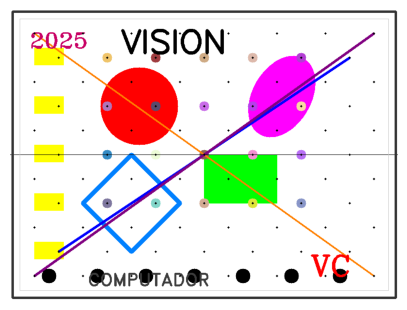

In [10]:
def create_geometric_base(w=800, h=600):
    """Crea una imagen sintética rica en detalles geométricos, texto y patrones."""
    img = np.ones((h, w, 3), dtype=np.uint8) * 255  # Fondo blanco

    # --- Figuras grandes ---
    cv.circle(img, (w//3, h//3), 80, (0, 0, 255), -1)  # Círculo rojo
    cv.rectangle(img, (w//2, h//2), (w//2+150, h//2+100), (0, 255, 0), -1)  # Rectángulo verde
    cv.ellipse(img, (int(w*0.7), int(h*0.3)), (60, 90), 30, 0, 360, (255, 0, 255), -1)  # Elipse magenta
    cv.polylines(img, [np.array([[150,400],[250,300],[350,400],[250,500]], np.int32)], True, (255,128,0), 8)  # Rombo naranja

    # --- Patrón de círculos en distintas zonas ---
    for y in range(100, h-100, 100):
        for x in range(100, w-100, 100):
            color = (np.random.randint(50,255), np.random.randint(50,255), np.random.randint(50,255))
            cv.circle(img, (x, y), 10, color, -1)

    # --- Pequeños detalles geométricos ---
    for i in range(80, 750, 100):
        cv.circle(img, (i, 550), 15, (0, 0, 0), -1)  # Círculos negros
    for j in range(80, 500, 100):
        cv.rectangle(img, (50, j), (110, j+35), (0, 255, 255), -1)  # Rectángulos amarillos

    # --- Líneas y diagonales ---
    cv.line(img, (100, 500), (700, 100), (255, 0, 0), 4)
    cv.line(img, (50, 50), (750, 550), (0, 128, 255), 2)
    cv.line(img, (50, 550), (750, 50), (128, 0, 128), 3)
    cv.line(img, (0, h//2), (w, h//2), (0, 0, 0), 1)  # Línea central horizontal

    # --- Texto en diferentes estilos y posiciones ---
    cv.putText(img, 'VISION', (230, 90), cv.FONT_HERSHEY_SIMPLEX, 2.2, (0, 0, 0), 6)
    cv.putText(img, 'COMPUTADOR', (160, 570), cv.FONT_HERSHEY_DUPLEX, 1.2, (60, 60, 60), 2)
    cv.putText(img, 'VC', (w-180, h-50), cv.FONT_HERSHEY_COMPLEX, 2, (0, 0, 255), 3)
    cv.putText(img, '2025', (40, 80), cv.FONT_HERSHEY_TRIPLEX, 1.5, (100, 0, 200), 2)

    # --- Rejilla de puntos para textura ---
    for y in range(50, h, 50):
        for x in range(50, w, 50):
            if (x+y) % 100 == 0:
                cv.circle(img, (x, y), 2, (0, 0, 0), -1)

    # --- Bordes decorativos dobles ---
    cv.rectangle(img, (5, 5), (w-5, h-5), (50, 50, 50), 3)
    cv.rectangle(img, (20, 20), (w-20, h-20), (200, 200, 200), 1)

    return img

base = create_geometric_base()

configs = [
    {"angle": 10, "tx": 20, "ty": 10, "scale": 1.00},
    {"angle": 15, "tx": -15, "ty": 5, "scale": 1.05},
    {"angle": -8, "tx": 30, "ty": -20, "scale": 0.95},
    {"angle": 25, "tx": -10, "ty": 15, "scale": 1.10},
    {"angle": -12, "tx": 15, "ty": 25, "scale": 0.98},
]

len(configs)
show_image(base)

## 2) Registro y métricas

In [11]:
def estimate_angle_from_H(H):
    # Aproximación: ángulo a partir de submatriz rotacional normalizada
    a = math.degrees(math.atan2(H[1,0], H[0,0]))
    return a

rows = []
methods = ["ORB", "SIFT", "AKAZE"]
for cfg in configs:
    for method in methods:
        img1, img2, H_gt = synthetic_affine_pair(base, angle_deg=cfg["angle"], tx=cfg["tx"], ty=cfg["ty"], scale=cfg["scale"])
        k1, d1 = detect_and_describe(img1, method=method)
        k2, d2 = detect_and_describe(img2, method=method)
        matches = match_descriptors(d1, d2, strategy="BF", ratio=0.75)
        if len(matches) < 4:
            rows.append({**cfg, "method": method, "matches": len(matches), "inliers": 0, "rmse_H": None, "angle_err_deg": None})
            continue
        H_est, mask = estimate_homography(k1, k2, matches, ransac_thresh=3.0)
        r = {
            **cfg,
            "method": method,
            "matches": len(matches),
            "inliers": int(mask.sum()) if mask is not None else None,
            "rmse_H": rmse(H_est, H_gt),
            "angle_err_deg": abs(estimate_angle_from_H(H_est) - cfg["angle"])
        }
        rows.append(r)

df = pd.DataFrame(rows)
df.to_csv(OUT_CSV, index=False)
df

,angle,tx,ty,scale,method,matches,inliers,rmse_H,angle_err_deg
0,10,20,10,1.00,ORB,1367,1001,0.117249,19.883876
1,10,20,10,1.00,SIFT,388,335,0.030306,20.005183
2,10,20,10,1.00,AKAZE,761,705,0.026147,19.999926
3,15,-15,5,1.05,ORB,1042,708,0.061445,29.926276
4,15,-15,5,1.05,SIFT,303,255,0.035525,30.012892
5,15,-15,5,1.05,AKAZE,636,577,0.032197,29.995796
6,-8,30,-20,0.95,ORB,1140,843,0.348000,16.012497
7,-8,30,-20,0.95,SIFT,358,322,0.010681,15.997990
8,-8,30,-20,0.95,AKAZE,699,624,0.096835,15.983964
9,25,-10,15,1.10,ORB,769,451,0.491648,49.975156


## 3) Visualización rápida (un caso)

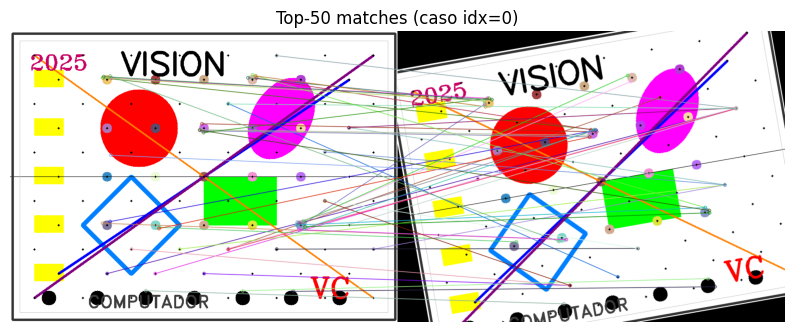

In [12]:
idx = 0
img1, img2, H_gt = synthetic_affine_pair(base, angle_deg=configs[idx]["angle"], tx=configs[idx]["tx"], ty=configs[idx]["ty"], scale=configs[idx]["scale"])
k1, d1 = detect_and_describe(img1, method="ORB")
k2, d2 = detect_and_describe(img2, method="ORB")
matches = match_descriptors(d1, d2, strategy="BF", ratio=0.75)
vis = cv.drawMatches(img1, k1, img2, k2, matches[:50], None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(cv.cvtColor(vis, cv.COLOR_BGR2RGB)); plt.title("Top-50 matches (caso idx=0)"); plt.axis('off'); plt.show()

## 4) Visualización por detector: todas las configuraciones
Para cada detector (ORB, SIFT, AKAZE), se muestran las correspondencias (top-50) para todas las configuraciones sintéticas definidas en `configs`. Esto permite comparar visualmente la robustez de cada método frente a rotación, traslación y escala.


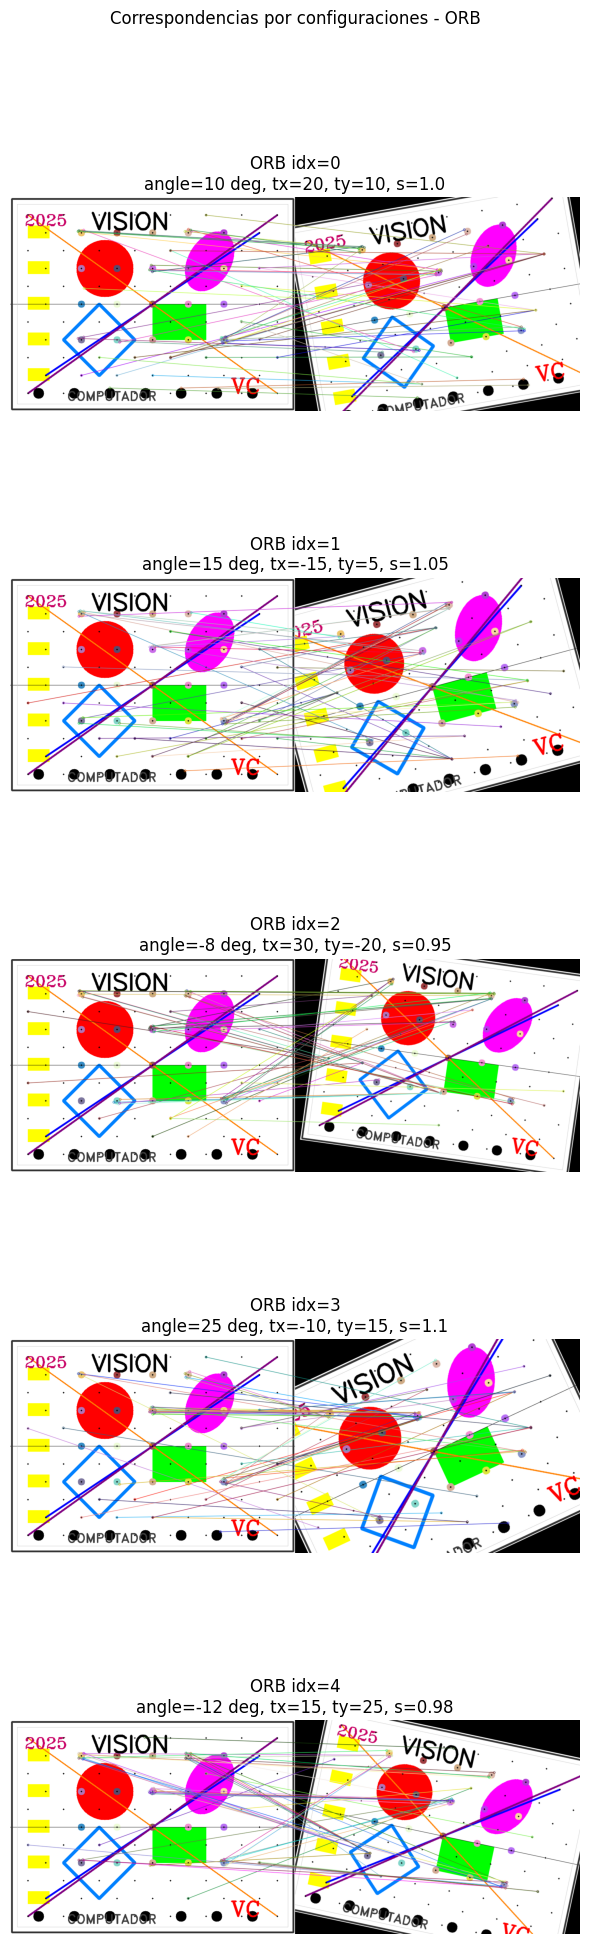

In [13]:
# ORB: visualizacion de todas las configuraciones
method = "ORB"
fig, axes = plt.subplots(len(configs), 1, figsize=(6, 4*len(configs)))
for i, cfg in enumerate(configs):
    img1, img2, H_gt = synthetic_affine_pair(
        base,
        angle_deg=cfg["angle"], tx=cfg["tx"], ty=cfg["ty"], scale=cfg["scale"]
    )
    k1, d1 = detect_and_describe(img1, method=method)
    k2, d2 = detect_and_describe(img2, method=method)
    matches = match_descriptors(d1, d2, strategy="BF", ratio=0.75)
    vis = cv.drawMatches(
        img1, k1, img2, k2, matches[:50], None,  # type: ignore[arg-type]
        flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )
    ax = axes[i] if isinstance(axes, np.ndarray) else axes
    ax.imshow(cv.cvtColor(vis, cv.COLOR_BGR2RGB))
    ax.set_title(f"{method} idx={i}\nangle={cfg['angle']} deg, tx={cfg['tx']}, ty={cfg['ty']}, s={cfg['scale']}")
    ax.axis('off')
plt.suptitle(f"Correspondencias por configuraciones - {method}", y=1.02)
plt.tight_layout()
plt.show()


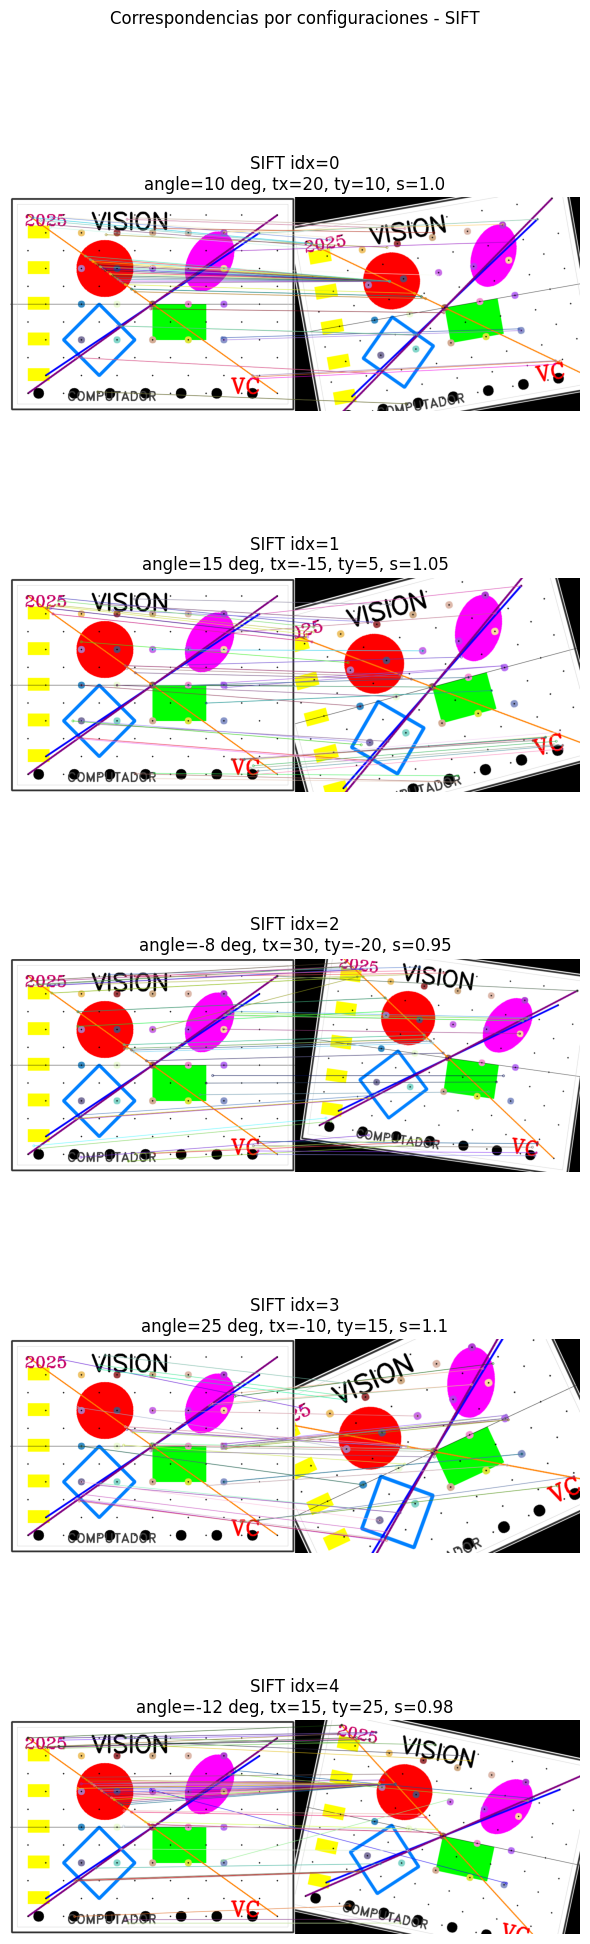

In [14]:
# SIFT: visualizacion de todas las configuraciones
method = "SIFT"
fig, axes = plt.subplots(len(configs), 1, figsize=(6, 4*len(configs)))
for i, cfg in enumerate(configs):
    img1, img2, H_gt = synthetic_affine_pair(
        base,
        angle_deg=cfg["angle"], tx=cfg["tx"], ty=cfg["ty"], scale=cfg["scale"]
    )
    k1, d1 = detect_and_describe(img1, method=method)
    k2, d2 = detect_and_describe(img2, method=method)
    matches = match_descriptors(d1, d2, strategy="BF", ratio=0.75)
    vis = cv.drawMatches(
        img1, k1, img2, k2, matches[:50], None,  # type: ignore[arg-type]
        flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )
    ax = axes[i] if isinstance(axes, np.ndarray) else axes
    ax.imshow(cv.cvtColor(vis, cv.COLOR_BGR2RGB))
    ax.set_title(f"{method} idx={i}\nangle={cfg['angle']} deg, tx={cfg['tx']}, ty={cfg['ty']}, s={cfg['scale']}")
    ax.axis('off')
plt.suptitle(f"Correspondencias por configuraciones - {method}", y=1.02)
plt.tight_layout()
plt.show()


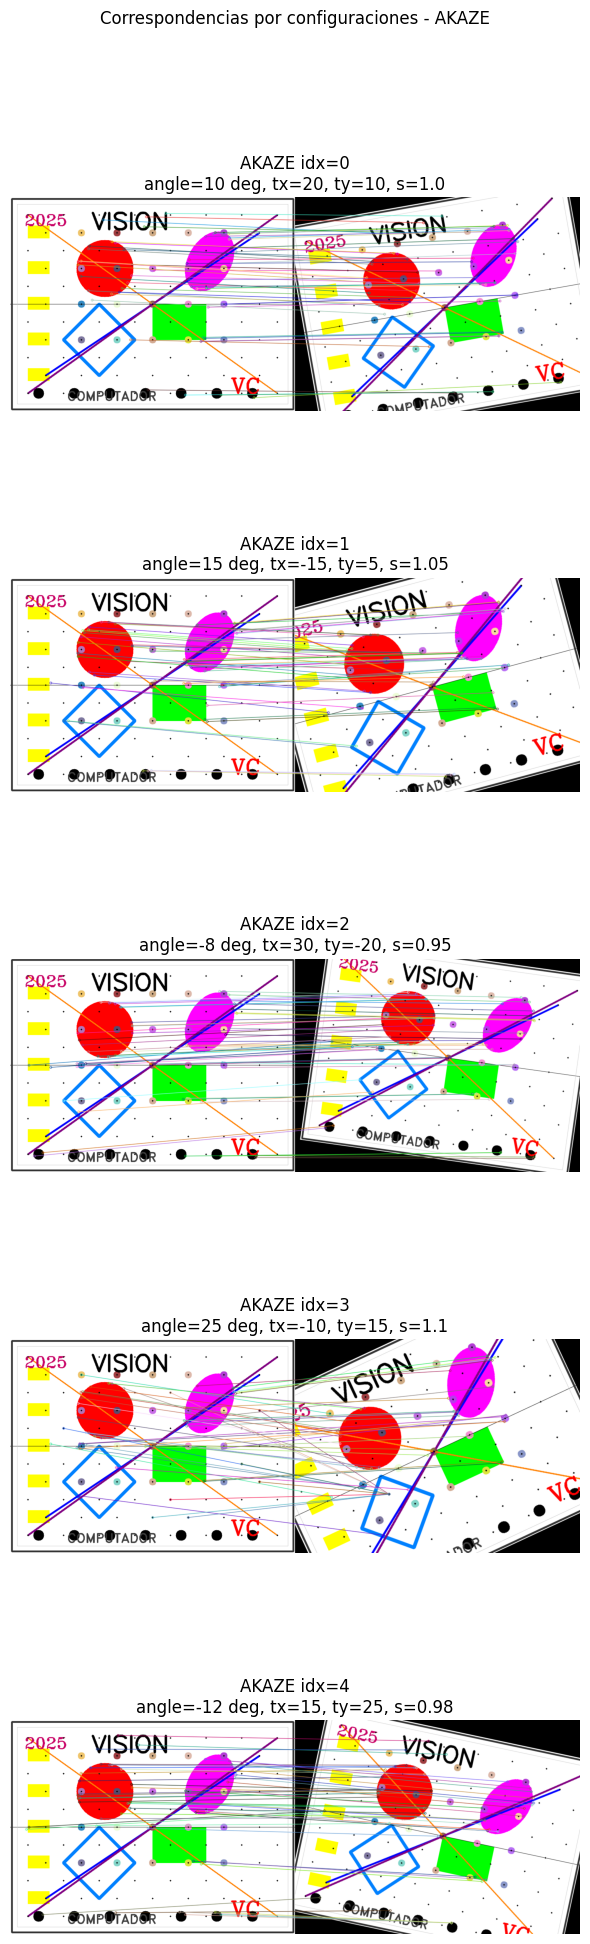

In [15]:
# AKAZE: visualizacion de todas las configuraciones
method = "AKAZE"
fig, axes = plt.subplots(len(configs), 1, figsize=(6, 4*len(configs)))
for i, cfg in enumerate(configs):
    img1, img2, H_gt = synthetic_affine_pair(
        base,
        angle_deg=cfg["angle"], tx=cfg["tx"], ty=cfg["ty"], scale=cfg["scale"]
    )
    k1, d1 = detect_and_describe(img1, method=method)
    k2, d2 = detect_and_describe(img2, method=method)
    matches = match_descriptors(d1, d2, strategy="BF", ratio=0.75)
    vis = cv.drawMatches(
        img1, k1, img2, k2, matches[:50], None,  # type: ignore[arg-type]
        flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )
    ax = axes[i] if isinstance(axes, np.ndarray) else axes
    ax.imshow(cv.cvtColor(vis, cv.COLOR_BGR2RGB))
    ax.set_title(f"{method} idx={i}\nangle={cfg['angle']} deg, tx={cfg['tx']}, ty={cfg['ty']}, s={cfg['scale']}")
    ax.axis('off')
plt.suptitle(f"Correspondencias por configuraciones - {method}", y=1.02)
plt.tight_layout()
plt.show()
